Nama : Angelina Nirmala Puteri Dika Praktiko

NPM  : 24083010055

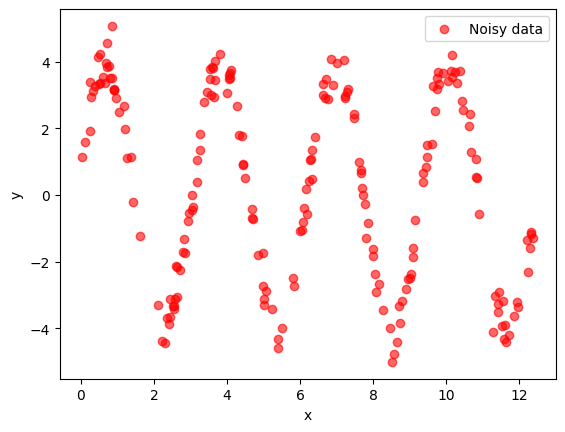

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of points
n = 200
NPM= 55

# Generate random x values between 0 and 4π
np.random.seed(NPM)
x = np.random.uniform(0, 4*np.pi, n)

# Original function
y_true = 4 * np.sin(2*x + 0.2)

# Add Gaussian noise
noise = np.random.normal(0, 0.4, n)  # mean=0, std=0.5
y_noisy = y_true + noise

# Plot
plt.scatter(x, y_noisy, label="Noisy data", color="red", alpha=0.6)
# plt.plot(np.sort(x), 4*np.sin(4*np.sort(x) + 0.2), label="True function", color="blue")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# TUGAS: temukan kembali fungsi asli dengan interpolasi dari titik-titik data acak (y_noisy)

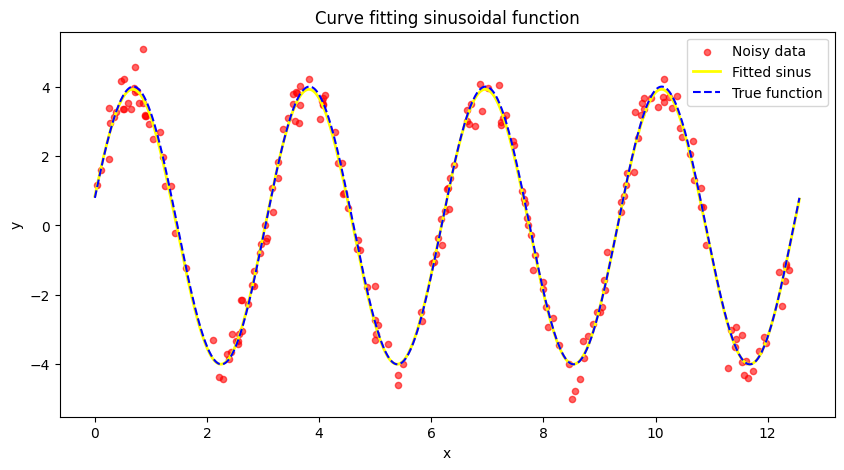

Hasil fitting:
Amplitudo (A)  = 3.959
Frekuensi (ω)  = 1.998
Fase (φ)       = 0.224
Offset (C)     = -0.038


In [ ]:
#Curve fitting
#model sinus umum
def sinus(x, A, omega, phi, C):
    return A * np.sin(omega * x + phi) + C

# Import curve_fit from scipy.optimize
from scipy.optimize import curve_fit

# Tebakan awal [A, omega, phi, C]
p0 = [3.5, 2.0, 0.0, 0.0]

# Lakukan fitting
params, cov = curve_fit(sinus, x, y_noisy, p0=p0)
A_fit, omega_fit, phi_fit, C_fit = params

# Buat data halus untuk visualisasi
x_fit = np.linspace(0, 4*np.pi, 1000)
y_fit = sinus(x_fit, *params)

# Plot
plt.figure(figsize=(10,5))
plt.scatter(x, y_noisy, s=20, alpha=0.6, label='Noisy data', color="red")
plt.plot(x_fit, y_fit, label=f'Fitted sinus', color="yellow", linewidth=2)
plt.plot(x_fit, 4*np.sin(2*x_fit+0.2), label='True function', color="blue", linestyle="--")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Curve fitting sinusoidal function")
plt.show()

# Cetak parameter hasil fitting
print(f"Hasil fitting:")
print(f"Amplitudo (A)  = {A_fit:.3f}")
print(f"Frekuensi (ω)  = {omega_fit:.3f}")
print(f"Fase (φ)       = {phi_fit:.3f}")
print(f"Offset (C)     = {C_fit:.3f}")

Titik merah menunjukkan data hasil pengukuran yang telah ditambahkan noise, sehingga tidak persis mengikuti pola sinus murni.

Garis biru putus-putus menggambarkan fungsi asli y = 4sin(2x+0.2), yang menjadi acuan utama.

Sementara, garis kuning merupakan hasil curve fitting dengan model sinusoidal. Dari visualisasi terlihat bahwa garis kuning hampir menumpuk garis biru, menandakan bahwa metode fitting berhasil menemukan kembali parameter fungsi asli (amplitudo, frekuensi, fase, dan offset) dengan sangat baik meskipun data awalnya penuh dnegan noise. Hal ini membuktikan bahwa pendekatan curve fitting efektif untuk mengestimasi bentuk dasar suatu fungsi dari data acak yang terdistorsi oleh gangguan(noise).

Heuristic sigma_est = 3.8059, s_heuristic = 2896.9854
Best s (CV) = 20.000000, CV MSE = 0.202959


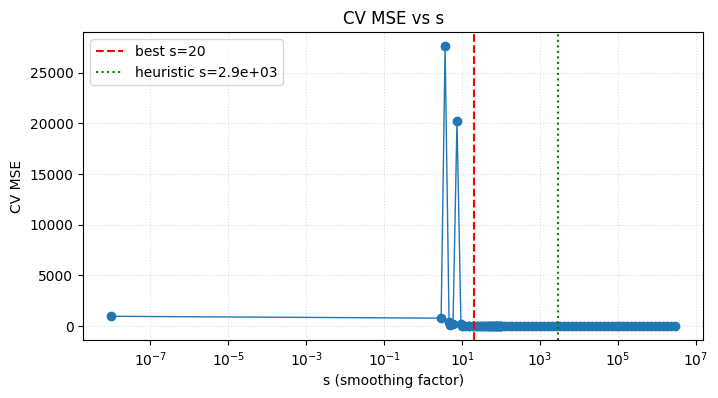

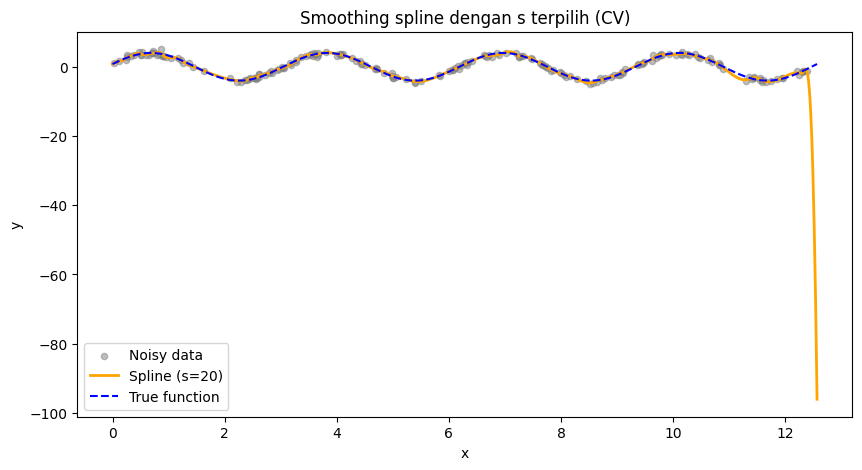

In [ ]:
# Heuristic s dari MAD

mad = np.median(np.abs(y_noisy - np.median(y_noisy)))
sigma_est = mad / 0.6745            # robust estimate of std
s_heuristic = n * (sigma_est**2)
print("Heuristic sigma_est = {:.4f}, s_heuristic = {:.4f}".format(sigma_est, s_heuristic))

# Fungsi CV untuk menilai s
def cv_mse_for_s(x_all, y_all, s_value, n_splits=5, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    mses = []
    for train_idx, test_idx in kf.split(x_all):
        x_tr, y_tr = x_all[train_idx], y_all[train_idx]
        x_te, y_te = x_all[test_idx], y_all[test_idx]
        order_tr = np.argsort(x_tr)
        spline = UnivariateSpline(x_tr[order_tr], y_tr[order_tr], s=s_value)
        y_pred = spline(x_te)
        mses.append(mean_squared_error(y_te, y_pred))
    return np.mean(mses)

# Grid search s sekitar heuristic
s_min = max(1e-8, s_heuristic / 1000)
s_max = s_heuristic * 1000 + 1e-8
s_candidates = np.unique(np.concatenate([
    np.linspace(0, 100, 21),
    np.logspace(np.log10(s_min+1e-12), np.log10(s_max), 60)
]))

scores = [cv_mse_for_s(x, y_noisy, s) for s in s_candidates]
best_idx = np.argmin(scores)
best_s = s_candidates[best_idx]
print("Best s (CV) = {:.6f}, CV MSE = {:.6f}".format(best_s, scores[best_idx]))


# Plot CV curve
plt.figure(figsize=(8,4))
safe_s = np.maximum(s_candidates, 1e-8)
plt.semilogx(safe_s, scores, marker='o', linewidth=1)
plt.axvline(best_s, color='red', linestyle='--', label=f'best s={best_s:.3g}')
plt.axvline(s_heuristic, color='green', linestyle=':', label=f'heuristic s={s_heuristic:.3g}')
plt.xlabel('s (smoothing factor)')
plt.ylabel('CV MSE')
plt.title('CV MSE vs s')
plt.legend()
plt.grid(True, which='both', ls=':', alpha=0.4)
plt.show()


# Visualisasi spline dengan best s
order = np.argsort(x)
x_sorted = x[order]
y_sorted = y_noisy[order]

spline_best = UnivariateSpline(x_sorted, y_sorted, s=best_s)
x_dense = np.linspace(0, 4*np.pi, 1000)

plt.figure(figsize=(10,5))
plt.scatter(x, y_noisy, s=20, alpha=0.5, color='gray', label='Noisy data')
plt.plot(x_dense, spline_best(x_dense), color='orange', linewidth=2, label=f'Spline (s={best_s:.3g})')
plt.plot(x_dense, 4*np.sin(2*x_dense+0.2), 'b--', label='True function')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Smoothing spline dengan s terpilih (CV)')
plt.legend()
plt.show()

Hasil analsis menunjukkan bahwa estimasi terhadapa noise menggunakan MAD menghasilkan sigma_est = 3.8059 dan diperoleh s_heuristic = 2896.9854 sebagai acuan awal smoothing factor.

Melalui cross-validation(CV) ditemukan bahwa nilai smoothing factor optimal adalah best s = 20, dengan CV MSE = 0.202959, jauh lebih kecil dari s_heuristic.

Hal ini menunjukkan bahwa spline dengan s = 20 cukup fleksibel untuk mengikuti tren data tanpa terlalu menempel pada noise, sedangkan s_heuristic yang besar akan membuat spline terlalu halus dan kehilangan pola sinus asli.

Pada visualisasi, titik-titik data noisy ditampilkan sebagai scatter plot abu-abu, spline halus dengan s = 20 ditampilkan sebagai garis oranye yang mengikuti pola sinus asli dan fungsi asli digambarkan sebagai garis biru putus-putus. Hasil ini menunjukkan bahwa spline dengan nilai s terpilih mampu menyeimbangkan antara overfitting dan underfitting, sehingga memberikan rekonstruksi data yang lebih representatif dibandingkan data noisy saja

Hasil fitting sinus:
Amplitudo (A)  = 3.959
Frekuensi (ω)  = 1.998
Fase (φ)       = 0.224
Offset (C)     = -0.038


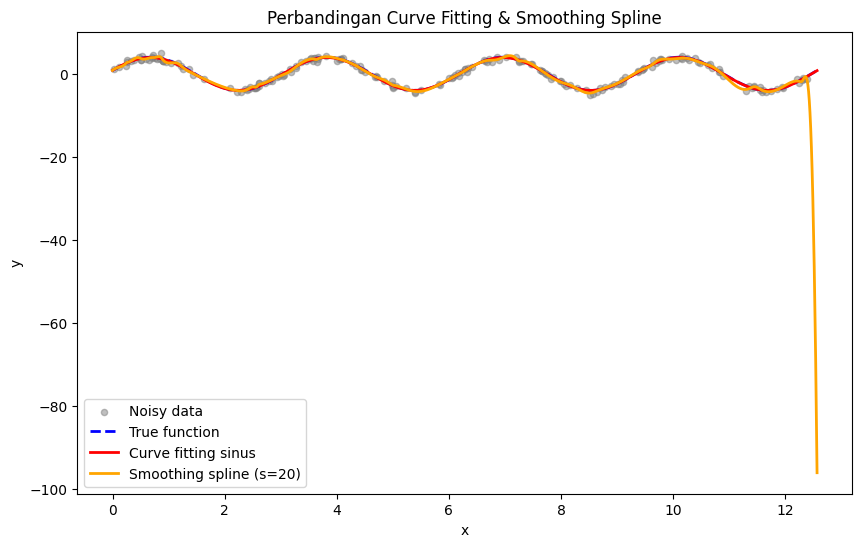

In [ ]:
# Curve fitting sinus
def sinus(x, A, omega, phi, C):
    return A * np.sin(omega * x + phi) + C

p0 = [4, 2, 0.2, 0]  # tebakan awal dekat fungsi asli
params, cov = curve_fit(
    sinus, x, y_noisy,
    p0=p0,
    bounds=([0,1,-np.pi,-5], [10,5,np.pi,5])
)
A_fit, omega_fit, phi_fit, C_fit = params

x_dense = np.linspace(0, 4*np.pi, 1000)
y_fit = sinus(x_dense, *params)
y_true_dense = 4 * np.sin(2*x_dense + 0.2)

print("Hasil fitting sinus:")
print(f"Amplitudo (A)  = {A_fit:.3f}")
print(f"Frekuensi (ω)  = {omega_fit:.3f}")
print(f"Fase (φ)       = {phi_fit:.3f}")
print(f"Offset (C)     = {C_fit:.3f}")


# Heuristic smoothing factor untuk spline
mad = np.median(np.abs(y_noisy - np.median(y_noisy)))
sigma_est = mad / 0.6745
s_heuristic = n * sigma_est**2


# Fungsi CV untuk menilai s
def cv_mse_for_s(x_all, y_all, s_value, n_splits=5, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    mses = []
    for train_idx, test_idx in kf.split(x_all):
        x_tr, y_tr = x_all[train_idx], y_all[train_idx]
        x_te, y_te = x_all[test_idx], y_all[test_idx]
        order_tr = np.argsort(x_tr)
        spline = UnivariateSpline(x_tr[order_tr], y_tr[order_tr], s=s_value)
        y_pred = spline(x_te)
        mses.append(mean_squared_error(y_te, y_pred))
    return np.mean(mses)


# Grid search s sekitar heuristic
s_min = max(1e-8, s_heuristic / 1000)
s_max = s_heuristic * 1000 + 1e-8
s_candidates = np.unique(np.concatenate([
    np.linspace(0, 100, 21),
    np.logspace(np.log10(s_min+1e-12), np.log10(s_max), 60)
]))

scores = [cv_mse_for_s(x, y_noisy, s) for s in s_candidates]
best_s = s_candidates[np.argmin(scores)]


# Fit spline terbaik
order = np.argsort(x)
x_sorted = x[order]
y_sorted = y_noisy[order]
spline_best = UnivariateSpline(x_sorted, y_sorted, s=best_s)
y_spline = spline_best(x_dense)


# Plot perbandingan Curve Fitting & Spline
plt.figure(figsize=(10,6))
plt.scatter(x, y_noisy, s=20, alpha=0.5, color='gray', label='Noisy data')
plt.plot(x_dense, y_true_dense, 'b--', linewidth=2, label='True function')
plt.plot(x_dense, y_fit, 'red', linewidth=2, label='Curve fitting sinus')
plt.plot(x_dense, y_spline, 'orange', linewidth=2, label=f'Smoothing spline (s={best_s:.3g})')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Perbandingan Curve Fitting & Smoothing Spline')
plt.legend()
plt.show()


Curve fitting menggunakan model sinus dengan parameter yang diestimasi dari data menghasilkan garis biru yang mengikuti bentuk dasar sinus asli, namun cenderung kaku karena mengikuti pola fungsi matematika yang ditentukan.

Sementara itu, smoothing spline dengan nilai smoothing factor optimal (best s) ditentukan melalui cross-validation, menghasilkan kurva oranye yang lebih fleksibel dalam menyesuaikan fluktuasi lokal data noisy tanpa terlalu menempel pada noise.

Titik-titik data noisy ditampilkan sebagai scatter plot abu-abu, sedangkan fungsi asli ditunjukkan sebagai garis biru putus-putus.

Saya memilih menggunakan metode Curve Fitting, karena meski smoothing spline dengan nilai s = 20 cukup fleksibel untuk mengikuti tren data, penggunaan curve fitting model sinus lebih tepat karena data asli memang berpola sinus.

Curve fitting menggunakan fungsi sinus sehingga mampu menangkap struktur dasar data secara lebih akurat dibandingkan spline yang hanya mendekati pola tanpa memperhatikan bentuk fungsinya. Selain itu, curve fitting lebih tahan terhadap risio overfitting terhadap noise, sementara spline cenderung menysesuiakn diri dengan fluktuasi kecil pada data. Dari interpretasi, curve fitting juga lebih unggul karena dapat menghasilkan parameter (amplitudo, frekuensi, dan fase), sedangkan smoothing spline hanya memberikan kurva halus tanpa menghasilkan parameter yang mudah dipahami.
Berdasarkan hasil dengan MAD dan cross-validation, smoothing spline sudah cukup optimal, tapi curve fitting tetao emberikan hasil yang lebih konsisten dengan pola sinus asli, terutama pada interval panjang dimana smoothing spline menunjukkan penurunan drastis di bagian ujung paling kanannya.

Kelebihan curve fitting:
1. Memberikan model parametris yang jelas sehingga setiap parameter memiliki interpretasi
2. Efektif untuk data dengan pola yang diketahui, speerti sinus, eksponensial, atau liner
3. Dapat digunakan untuk prediksi atau simulasi dengan fungsi yang diperoleh


Kekurangan curve fitting:
1. Kurang fleksibel jika data memiliki fluktuasi loal atau noise yang signifikan, karena model cenderung mengikuti bentuk global
2. Hasil sangat tergantung pada asumsi bentuk fungsi dan tebakan awal parameter, jika asumsi salah maka hasil fitting bisa jauh dari data
3. Tidak mampu menyesuaikan variasi kecil atau outlier tanpa memengaruhi seluruh model